# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from gensim.models import KeyedVectors
from tqdm import tqdm
import os
from collections import Counter


In [2]:
data = pd.read_csv('preprocessed_data.csv',nrows=50000)

data.columns.values

array(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'essay', 'price', 'project_title'], dtype=object)

In [3]:
data.shape

(50000, 10)

# Preprocess categorical features PROJECT TITLE

# 1) project title

In [4]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [5]:
preprocessed_titles = preprocess_text(data['project_title'].values)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 39085.51it/s]


# creating new column with preprocessed project title values.

In [6]:
data['cleaned_project_title']=preprocessed_titles

In [7]:
data=data.drop('project_title',axis=1)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,cleaned_project_title
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,wanted projector hungry learners
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,soccer equipment awesome middle school students
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,techie kindergarteners
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,interactive math tools


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33, stratify=y)

In [9]:

    
    
print(xtrain.shape)
print(xtest.shape)
print('-'*100)
print(ytrain.shape)
print(ytest.shape)

(33500, 9)
(16500, 9)
----------------------------------------------------------------------------------------------------
(33500,)
(16500,)


1)we have 2 text features "essay" and "cleaned_project_title". we encode/vectorise it using BOW and TFIDF

<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

# 1)BOW vectorization

In [10]:
essay_bow=xtrain['essay'].values


In [11]:
vect=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect.fit(essay_bow)
#now we have learnt the vocab of xtrain.lets try to transofrm test and cv data using xtrain vocab
xtr_bow_essay=vect.transform(essay_bow)
xtest_bow_essay=vect.transform(xtest['essay'].values)
#xcv_bow_essay=vect.transform(xcv['essay'].values)
essay_bow_features=vect.get_feature_names()

print('train_essay bow shape',xtr_bow_essay.shape,ytrain.shape)
print('test_essay bow shape',xtest_bow_essay.shape,ytest.shape)
#print('cv_essay bow shape',xcv_bow_essay.shape,ycv.shape)

train_essay bow shape (33500, 5000) (33500,)
test_essay bow shape (16500, 5000) (16500,)


In [12]:
print('cv_essay bow feature names',essay_bow_features[:10])

cv_essay bow feature names ['000', '10', '100', '100 free', '100 percent', '100 students', '100 students receive', '100 students receive free', '11', '12']


# BOW vectorization project_title

In [13]:
prjtitle_bow=xtrain['cleaned_project_title'].values

In [14]:
vect=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect.fit(prjtitle_bow)
#now we have learnt the vocab of xtrain.lets try to transform test and cv data using xtrain vocab
xtr_bow_prjtitle=vect.transform(prjtitle_bow)
xtest_bow_prjtitle=vect.transform(xtest['cleaned_project_title'].values)
#xcv_bow_prjtitle=vect.transform(xcv['cleaned_project_title'].values)
prjtitle_bow_features=vect.get_feature_names()

print('train_prj title bow shape',xtr_bow_prjtitle.shape,ytrain.shape)
print('test_prj title bow shape',xtest_bow_prjtitle.shape,ytest.shape)
#print('cv_prj title bow shape',xcv_bow_prjtitle.shape,ycv.shape)
print(prjtitle_bow_features[:10])

train_prj title bow shape (33500, 2458) (33500,)
test_prj title bow shape (16500, 2458) (16500,)
['05', '10', '100', '101', '16', '1st', '1st grade', '1st graders', '2016', '2017']


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# 1)school_state (one hot encoding)

In [15]:

vect=CountVectorizer(binary=True)
vect.fit(xtrain['school_state'].values)
xtrain_ohe_school_state=vect.transform(xtrain['school_state'].values)
#xcv_ohe_school_state=vect.transform(xcv['school_state'].values)
xtest_ohe_school_state=vect.transform(xtest['school_state'].values)
school_state_feature=vect.get_feature_names()

print('school_state xtrain shape',xtrain_ohe_school_state.shape,ytrain.shape)
print('school_state xtest shape',xtest_ohe_school_state.shape,ytest.shape)
#print('school_state xcv shape',xcv_ohe_school_state.shape,ycv.shape)

school_state xtrain shape (33500, 51) (33500,)
school_state xtest shape (16500, 51) (16500,)


# 2)teacher_prefix one hot encoding

In [18]:
vect=CountVectorizer(binary=True)
vect.fit(xtrain['teacher_prefix'].values)
xtrain_ohe_teacher_prefix=vect.transform(xtrain['teacher_prefix'].values)
xtest_ohe_teacher_prefix=vect.transform(xtest['teacher_prefix'].values)
teacher_prefix_feature=vect.get_feature_names()
#xcv_ohe_teacher_prefix=vect.transform(xcv['teacher_prefix'].values)
print('xtrain_ohe_teacher shape',xtrain_ohe_teacher_prefix.shape,ytrain.shape)
print('xtest_ohe_teacher shape',xtest_ohe_teacher_prefix.shape,ytest.shape)
#print('xcv_ohe_teacher_prefix shape',xcv_ohe_teacher_prefix.shape,ycv.shape)


xtrain_ohe_teacher shape (33500, 5) (33500,)
xtest_ohe_teacher shape (16500, 5) (16500,)


# 3)project_grade_category ohe hot encoding

In [19]:
vect=CountVectorizer(binary=True)
vect.fit(xtrain['project_grade_category'].values)
xtrain_ohe_project_grade_category=vect.transform(xtrain['project_grade_category'].values)
xtest_ohe_project_grade_category=vect.transform(xtest['project_grade_category'].values)
project_grade_category_feature=vect.get_feature_names()
#xcv_ohe_project_grade_category=vect.transform(xcv['project_grade_category'].values)
print('xtrain_ohe_project_grade_category shape',xtrain_ohe_project_grade_category.shape,ytrain.shape)
print('xtest_ohe_project_grade_category shape',xtest_ohe_project_grade_category.shape,ytest.shape)
#print('xcv_ohe_teacher_project_grade_category shape',xcv_ohe_project_grade_category.shape,ycv.shape)



xtrain_ohe_project_grade_category shape (33500, 4) (33500,)
xtest_ohe_project_grade_category shape (16500, 4) (16500,)


# 4)clean_categories one hot encoding

In [20]:
vect=CountVectorizer(binary=True)
vect.fit(xtrain['clean_categories'].values)
xtrain_ohe_clean_categories=vect.transform(xtrain['clean_categories'].values)
xtest_ohe_clean_categories=vect.transform(xtest['clean_categories'].values)
#xcv_ohe_clean_categories=vect.transform(xcv['clean_categories'].values)
clean_categories_feature=vect.get_feature_names()
print('xtrain_ohe_clean_categories shape',xtrain_ohe_clean_categories.shape,ytrain.shape)
print('xtest_ohe_clean_categories shape',xtest_ohe_clean_categories.shape,ytest.shape)
#print('xcv_ohe_teacher_clean_categories shape',xcv_ohe_clean_categories.shape,ycv.shape)
print(vect.get_feature_names())



xtrain_ohe_clean_categories shape (33500, 9) (33500,)
xtest_ohe_clean_categories shape (16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


# 5)clean_subcategories one hot encoding

In [21]:
vect=CountVectorizer(binary=True)
vect.fit(xtrain['clean_subcategories'].values)
xtrain_ohe_clean_subcategories=vect.transform(xtrain['clean_subcategories'].values)
xtest_ohe_clean_subcategories=vect.transform(xtest['clean_subcategories'].values)
#xcv_ohe_clean_subcategories=vect.transform(xcv['clean_subcategories'].values)
clean_subcategories_feature=vect.get_feature_names()
print('xtrain_ohe_clean_subcategories shape',xtrain_ohe_clean_subcategories.shape,ytrain.shape)
print('xtest_ohe_clean_subcategories shape',xtest_ohe_clean_subcategories.shape,ytest.shape)
#print('xcv_ohe_teacher_clean_subcategories shape',xcv_ohe_clean_subcategories.shape,ycv.shape)
print(vect.get_feature_names())



xtrain_ohe_clean_subcategories shape (33500, 30) (33500,)
xtest_ohe_clean_subcategories shape (16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


# Normalize numerical features "price" and "previosuly submitted projects count"

# 1)price

In [22]:
from sklearn.preprocessing import Normalizer
norm=Normalizer()
norm.fit(xtrain['price'].values.reshape(-1,1))
xtrain_norm_price=norm.transform(xtrain['price'].values.reshape(-1,1))
xtest_norm_price=norm.transform(xtest['price'].values.reshape(-1,1))
#xcv_norm_price=norm.transform(xcv['price'].values.reshape(-1,1))
print('xtrain_norm_price shape',xtrain_norm_price.shape,ytrain.shape)
print('xtest_norm_price shape',xtest_norm_price.shape,ytest.shape)
#print('xcv_norm_price shape',xcv_norm_price.shape,ycv.shape)

xtrain_norm_price shape (33500, 1) (33500,)
xtest_norm_price shape (16500, 1) (16500,)


# 2)teacher_number_of_previously_posted_projects

In [23]:
from sklearn.preprocessing import Normalizer
norm=Normalizer()
norm.fit(xtrain['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
xtrain_norm_prjcount=norm.transform(xtrain['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
xtest_norm_prjcount=norm.transform(xtest['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#xcv_norm_prjcount=norm.transform(xcv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print('xtrain_norm_prjcount shape',xtrain_norm_prjcount.shape,ytrain.shape)
print('xtest_norm_prjcount shape',xtest_norm_prjcount.shape,ytest.shape)
#print('xcv_norm_prjcount shape',xcv_norm_prjcount.shape,ycv.shape)


xtrain_norm_prjcount shape (33500, 1) (33500,)
xtest_norm_prjcount shape (16500, 1) (16500,)


1) https://stackoverflow.com/a/19710648/4084039 : concatenate two matrices

#lets combine all the features into one single stack.



# SET1

In [24]:
from scipy.sparse import hstack
xtrain_hstack_set1 = hstack((xtr_bow_essay,xtr_bow_prjtitle,xtrain_ohe_school_state, xtrain_ohe_teacher_prefix, xtrain_ohe_project_grade_category,xtrain_ohe_clean_categories,xtrain_ohe_clean_subcategories, xtrain_norm_price,xtrain_norm_prjcount)).tocsr()

xtest_hstack_set1 = hstack((xtest_bow_essay,xtest_bow_prjtitle,xtest_ohe_school_state,xtest_ohe_teacher_prefix,xtest_ohe_project_grade_category,xtest_ohe_clean_categories,xtest_ohe_clean_subcategories,xtest_norm_price,xtest_norm_prjcount)).tocsr()

#xcv_hstack_set1=hstack((xcv_bow_essay,xcv_bow_prjtitle,xcv_ohe_school_state,xcv_ohe_teacher_prefix,xcv_ohe_project_grade_category,xcv_ohe_clean_categories,xcv_ohe_clean_subcategories,xcv_norm_price,xcv_norm_prjcount)).tocsr()
print("Data Final matrix")
print(xtrain_hstack_set1.shape, ytrain.shape)
print(xtest_hstack_set1.shape, ytest.shape)
#print(xcv_hstack_set1.shape, ycv.shape)




Data Final matrix
(33500, 7559) (33500,)
(16500, 7559) (16500,)


# TFIDF vectorization

# 1)essay

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
vect=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect.fit(xtrain['essay'].values)
#now we have learnt the vocab of xtrain.lets try to transofrm test and cv data using xtrain vocab
xtr_tfidf_essay=vect.transform(xtrain['essay'].values)
xtest_tfidf_essay=vect.transform(xtest['essay'].values)
#xcv_tfidf_essay=vect.transform(xcv['essay'].values)
essay_tfidf_features=vect.get_feature_names()

print('train_essay bow shape',xtr_tfidf_essay.shape,ytrain.shape)
print('test_essay bow shape',xtest_tfidf_essay.shape,ytest.shape)
#print('cv_essay bow shape',xcv_tfidf_essay.shape,ycv.shape)

train_essay bow shape (33500, 5000) (33500,)
test_essay bow shape (16500, 5000) (16500,)


# 2)project_title

In [43]:
vect=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect.fit(xtrain['cleaned_project_title'].values)
#now we have learnt the vocab of xtrain.lets try to transofrm test and cv data using xtrain vocab
xtr_tfidf_prjtitle=vect.transform(xtrain['cleaned_project_title'].values)
xtest_tfidf_prjtitle=vect.transform(xtest['cleaned_project_title'].values)
#xcv_tfidf_prjtitle=vect.transform(xcv['cleaned_project_title'].values)
prjtitle_tfidf_features=vect.get_feature_names()

print('train_prjtitle bow shape',xtr_tfidf_prjtitle.shape,ytrain.shape)
print('test_prjtitle bow shape',xtest_tfidf_prjtitle.shape,ytest.shape)
#print('cv_prjtitle bow shape',xcv_tfidf_prjtitle.shape,ycv.shape)

train_prjtitle bow shape (33500, 2458) (33500,)
test_prjtitle bow shape (16500, 2458) (16500,)


# stack the tfidf features with the other one hot encoded features to get set2

# SET2

In [44]:
from scipy.sparse import hstack
xtrain_hstack_set2 = hstack((xtr_tfidf_essay,xtr_tfidf_prjtitle,xtrain_ohe_school_state, xtrain_ohe_teacher_prefix, xtrain_ohe_project_grade_category,xtrain_ohe_clean_categories,xtrain_ohe_clean_subcategories, xtrain_norm_price,xtrain_norm_prjcount)).tocsr()

xtest_hstack_set2 = hstack((xtest_tfidf_essay,xtest_tfidf_prjtitle,xtest_ohe_school_state,xtest_ohe_teacher_prefix,xtest_ohe_project_grade_category,xtest_ohe_clean_categories,xtest_ohe_clean_subcategories,xtest_norm_price,xtest_norm_prjcount)).tocsr()

#xcv_hstack_set2=hstack((xcv_tfidf_essay,xcv_tfidf_prjtitle,xcv_ohe_school_state,xcv_ohe_teacher_prefix,xcv_ohe_project_grade_category,xcv_ohe_clean_categories,xcv_ohe_clean_subcategories,xcv_norm_price,xcv_norm_prjcount)).tocsr()

print("Data Final matrix")
print(xtrain_hstack_set2.shape, ytrain.shape)
print(xtest_hstack_set2.shape, ytest.shape)
#print(xcv_hstack_set2.shape, ycv.shape)


Data Final matrix
(33500, 7559) (33500,)
(16500, 7559) (16500,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>


#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

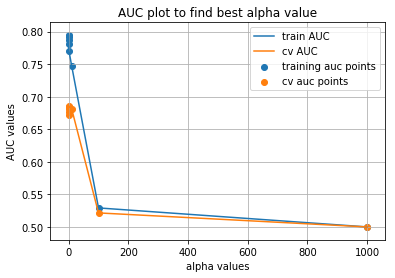

this is not readable,hence convert alpha values to original values


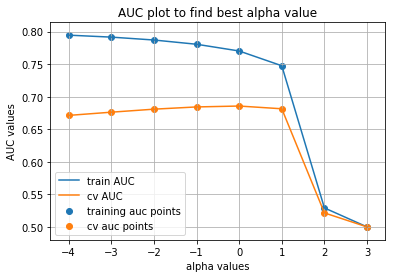

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.119213,0.008769,0.012992,0.000817,0.0001,{'alpha': 0.0001},0.676723,0.663968,0.673174,0.671288,0.005375,6,0.794594,0.795212,0.793744,0.794517,0.000602
1,0.109141,0.008924,0.013988,0.001411,0.001,{'alpha': 0.001},0.681026,0.669001,0.678577,0.676202,0.005189,5,0.791820,0.792066,0.790605,0.791497,0.000639
2,0.119262,0.012229,0.015657,0.002866,0.01,{'alpha': 0.01},0.685131,0.673695,0.683677,0.680835,0.005083,4,0.787640,0.787544,0.785984,0.787056,0.000759
3,0.117268,0.005435,0.013658,0.000942,0.1,{'alpha': 0.1},0.688404,0.676998,0.687420,0.684274,0.005161,2,0.781331,0.781103,0.779182,0.780538,0.000964
4,0.149496,0.008161,0.020655,0.004640,1,{'alpha': 1},0.690440,0.677732,0.688794,0.685656,0.005643,1,0.770941,0.771155,0.768484,0.770194,0.001212


In [45]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
import math
import warnings
warnings.filterwarnings("ignore")


train_auc=[]
cv_auc=[]

#idea

#here write a for loop using logarithms to get powers of 10, also use randint starting from megative integers till postitive integers.

clf=MultinomialNB()
params={'alpha':[10**i for i in range(-4,4)]}
RSearch=GridSearchCV(clf,params, cv=3, scoring='roc_auc', return_train_score=True ,n_jobs=-1)
RSearch.fit(xtrain_hstack_set1,ytrain)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html (cv_results_)

result=pd.DataFrame.from_dict(RSearch.cv_results_)
result=result.sort_values(['param_alpha'])
train_auc=result['mean_train_score']
train_auc_std=result['std_train_score']
cv_auc=result['mean_test_score']
cv_auc_std=result['std_test_score']
alpha=result['param_alpha']

plt.plot(alpha,train_auc,label='train AUC') #train auc scores
plt.plot(alpha,cv_auc,label='cv AUC') #cv auc scores

plt.scatter(alpha,train_auc,label='training auc points')
plt.scatter(alpha,cv_auc,label='cv auc points')

plt.legend()
plt.xlabel('alpha values')
plt.ylabel('AUC values')
plt.title('AUC plot to find best alpha value')
plt.grid()
plt.show()
print('this is not readable,hence convert alpha values to original values')
#https://stackoverflow.com/questions/49209338/converting-log-values-back-to-number/50980215

plt.plot([np.log10(alpha[i]) for i in range(len(alpha))],train_auc,label='train AUC') #train auc scores
plt.plot([np.log10(alpha[i]) for i in range(len(alpha))],cv_auc,label='cv AUC') #cv auc scores

plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))],train_auc,label='training auc points')
plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))],cv_auc,label='cv auc points')

plt.legend()
plt.xlabel('alpha values')
plt.ylabel('AUC values')
plt.title('AUC plot to find best alpha value')
plt.grid()
plt.show()
result.head()








In [46]:
best_alpha=RSearch.best_estimator_
print("the best alpha value is",best_alpha.alpha)


the best alpha value is 1


# FOR SET2

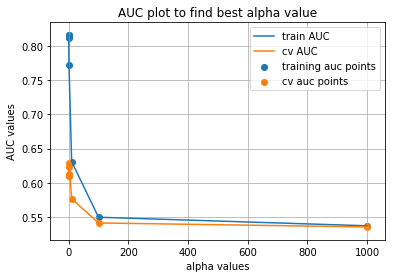

this is not readable,hence convert alpha values to original values


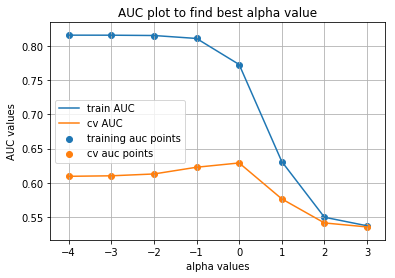

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.114598,0.005238,0.013990,0.000818,0.0001,{'alpha': 0.0001},0.617438,0.601889,0.609137,0.609489,0.006353,5,0.817962,0.815230,0.814635,0.815942,0.001449
1,0.115598,0.008953,0.013985,0.001633,0.001,{'alpha': 0.001},0.617912,0.602684,0.610087,0.610228,0.006218,4,0.817938,0.815169,0.814563,0.815890,0.001469
2,0.119254,0.010782,0.015658,0.000471,0.01,{'alpha': 0.01},0.619974,0.606083,0.612683,0.612914,0.005673,3,0.817613,0.814632,0.814025,0.815424,0.001568
3,0.118930,0.005095,0.012992,0.001414,0.1,{'alpha': 0.1},0.627806,0.617560,0.622885,0.622751,0.004184,2,0.813899,0.809990,0.809435,0.811108,0.001986
4,0.112601,0.006940,0.016324,0.001246,1,{'alpha': 1},0.634912,0.621974,0.630206,0.629031,0.005347,1,0.776077,0.772719,0.770165,0.772987,0.002421


In [47]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation


train_auc=[]
cv_auc=[]

#idea

#here write a for loop using logarithms to get powers of 10, also use randint starting from megative integers till postitive integers.

clf=MultinomialNB()
params={'alpha':[10**i for i in range(-4,4)]}
RSearch1=GridSearchCV(clf,params, cv=3, scoring='roc_auc', return_train_score=True ,n_jobs=-1)
RSearch1.fit(xtrain_hstack_set2,ytrain)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html (cv_results_)

result=pd.DataFrame.from_dict(RSearch1.cv_results_)
result=result.sort_values(['param_alpha'])
train_auc=result['mean_train_score']
train_auc_std=result['std_train_score']
cv_auc=result['mean_test_score']
cv_auc_std=result['std_test_score']
alpha=result['param_alpha']

plt.plot(alpha,train_auc,label='train AUC') #train auc scores
plt.plot(alpha,cv_auc,label='cv AUC') #cv auc scores

plt.scatter(alpha,train_auc,label='training auc points')
plt.scatter(alpha,cv_auc,label='cv auc points')

plt.legend()
plt.xlabel('alpha values')
plt.ylabel('AUC values')
plt.title('AUC plot to find best alpha value')
plt.grid()
plt.show()
print('this is not readable,hence convert alpha values to original values')

plt.plot([np.log10(alpha[i]) for i in range(len(alpha))],train_auc,label='train AUC') #train auc scores
plt.plot([np.log10(alpha[i]) for i in range(len(alpha))],cv_auc,label='cv AUC') #cv auc scores

plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))],train_auc,label='training auc points')
plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))],cv_auc,label='cv auc points')

plt.legend()
plt.xlabel('alpha values')
plt.ylabel('AUC values')
plt.title('AUC plot to find best alpha value')
plt.grid()
plt.show()
result.head()


In [49]:
best_alpha1=RSearch1.best_estimator_
print("the best alpha value is",best_alpha1.alpha)

the best alpha value is 1


# NOW PREDICT ON THE TEST DATA (SET1)(BOW)

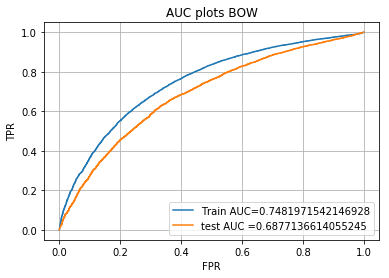

In [50]:
from sklearn.metrics import roc_curve, auc
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred


clf1=MultinomialNB(alpha=best_alpha.alpha)
clf1.fit(xtrain_hstack_set1,ytrain)

y_train_pred=batch_predict(clf1,xtrain_hstack_set1)
y_test_pred=batch_predict(clf1,xtest_hstack_set1)

train_fpr,train_tpr,tr_thresholds=roc_curve(ytrain,y_train_pred)
test_fpr,test_tpr,te_thresholds=roc_curve(ytest,y_test_pred)
auc1=auc(test_fpr, test_tpr)
plt.plot(train_fpr,train_tpr,label='Train AUC='+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='test AUC ='+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.title('AUC plots BOW')
plt.grid()
plt.show()

# NOW PREDICT ON THE TEST DATA (SET2)(TFIDF)

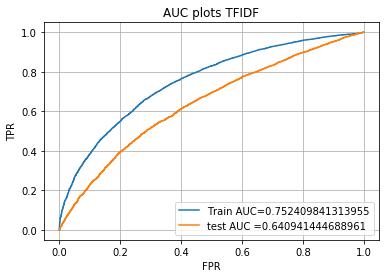

In [51]:
from sklearn.metrics import roc_curve, auc
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred


clf=MultinomialNB(alpha=best_alpha1.alpha)
clf.fit(xtrain_hstack_set2,ytrain)

y_train_pred=batch_predict(clf,xtrain_hstack_set2)
y_test_pred=batch_predict(clf,xtest_hstack_set2)

train_fpr,train_tpr,tr_thresholds=roc_curve(ytrain,y_train_pred)
test_fpr1,test_tpr1,te_thresholds=roc_curve(ytest,y_test_pred)
auc2=auc(test_fpr1,test_tpr1)
plt.plot(train_fpr,train_tpr,label='Train AUC='+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr1,test_tpr1,label='test AUC ='+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.title('AUC plots TFIDF')
plt.grid()
plt.show()

# TOP 20 FEATURES

In [52]:
import numpy as np
feature_list=[]
#names=[]
#feature_list=list(feature_list)
feature_list.extend(essay_bow_features)
feature_list.extend(prjtitle_bow_features)
feature_list.extend(school_state_feature)
feature_list.extend(teacher_prefix_feature)
feature_list.extend(project_grade_category_feature)
feature_list.extend(clean_categories_feature)
feature_list.extend(clean_subcategories_feature)
feature_list.extend(['price'])
feature_list.extend(['teacher_number_of_previously_posted_projects'])

print(len(feature_list))

#print(feature_list)

top_20_index=np.argsort(((clf1.feature_log_prob_)[0])[::-1])[:20]
names=np.take(feature_list,top_20_index)
print(' top 20 features')
print('-'*100)
print(names)
print('-'*100)
print('top 20 feature indices'),
print(top_20_index)
#for i in top_20_index:
    #print(feature_list[i])

#feature_list[7]


7559
 top 20 features
----------------------------------------------------------------------------------------------------
['asked students' 'impairments' 'help provide' 'disorder'
 'important students' 'consideration' 'expressed' 'economically' 'anyone'
 'learning experiences' 'connected' 'apart' 'help increase' 'endless'
 'learning environment' 'learning disabilities' 'classroom full'
 'energetic' 'experiences my' 'diverse backgrounds']
----------------------------------------------------------------------------------------------------
top 20 feature indices
[ 330 2000 1889 1116 2007  877 1458 1223  278 2320  872  282 1881 1288
 2317 2314  696 1291 1439 1130]


# confusion matrix

In [53]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(ytrain, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(ytest, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.47448871446101554 for threshold 0.851
Train confusion matrix
[[ 3705  1660]
 [ 8804 19331]]
Test confusion matrix
[[1411 1231]
 [4585 9273]]


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [54]:
# http://zetcode.com/python/prettytable/ 
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
from prettytable import PrettyTable
pt=PrettyTable() 
pt.field_names = ["Vectorizer", "Model", "Hyper-Parameter", "AUC"] 
pt.add_row([" BOW ", "Naive Bayes", best_alpha.alpha,auc1])
pt.add_row([" TFIDF ", "Naive Bayes", best_alpha1.alpha, auc2]) 
print(pt)

+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper-Parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    BOW     | Naive Bayes |        1        | 0.6877136614055245 |
|   TFIDF    | Naive Bayes |        1        | 0.640941444688961  |
+------------+-------------+-----------------+--------------------+
